In [3]:
# from gorillatracker.args import TrainingArgs
import json
from pathlib import Path
from typing import Any, Callable, Dict, Literal, Tuple, Type, Union
from urllib.parse import urlparse

import cv2
import cv2.typing as cvt
import pandas as pd
import torch
import torchvision.transforms as transforms
import wandb
from PIL import Image
from torch.utils.data import Dataset
from torchvision.transforms import v2 as transforms_v2
from tqdm import tqdm

from gorillatracker.model import BaseModule, get_model_cls
from gorillatracker.train_utils import get_dataset_class
from gorillatracker.type_helper import Label
from gorillatracker.utils.embedding_generator import load_model_from_wandb, generate_embeddings_from_tracked_video
from gorillatracker.scripts.create_dataset_from_videos import _crop_image, _get_frames_for_ids
from gorillatracker.model import SwinV2LargeWrapper
from gorillatracker.transform_utils import SquarePad

wandbRun = Any

In [4]:
import json
import tempfile
import os
from pathlib import Path
from typing import Dict, List, Optional, Union

import ultralytics
from ultralytics import YOLO
import tempfile

from gorillatracker.scripts.video_json_tracker import GorillaVideoTracker


def create_tracked_bbox_json(video_path: str):
    """Create tracked Bounding Boxes json.

    Args:
        video_path: Path to the video.
        out_path: Path to save the JSON file to.

    Returns:
        List of Bounding Boxes.
    """
    with tempfile.TemporaryDirectory() as temp_dir:
        file_name = Path(video_path).stem
        json_path = f"{temp_dir}/{file_name}.json"
        body_model_path = "/workspaces/gorillatracker/models/yolov8n_gorillabody_ybyh495y.pt"
        face_model_path = "/workspaces/gorillatracker/models/yolov8n_gorillaface_a2mkg0zc.pt"
        precict_video_simple(video_path, json_path, YOLO(face_model_path), YOLO(body_model_path), {})

        tracker = GorillaVideoTracker(path=temp_dir)
        tracker.track_file(json_path)
        # read out json in out_path directory with tracked
        tracked_json_path = f"{temp_dir}/{file_name}_tracked.json"
        with open(tracked_json_path, "r") as file:
            tracked_json = json.load(file)
        tracked_json = tracked_json["labels"]
        return tracked_json


def precict_video_simple(
    video_path: str,
    json_path: str,
    face_model: YOLO,
    body_model: YOLO,
    yolo_args: Dict[str, Union[bool, int, str]] = {},
) -> None:
    """
    Predicts labels for objects in a video using a YOLO body and face model

    Parameters:
    - video_path (str): The path to the input video file.
    - json_path (str): The path to the output JSON file.
    - model (YOLO): The YOLO model to use for prediction.
    - yolo_args (Dict): Additional arguments to pass to the YOLO model.
    Returns:
        None
    """

    face_results = face_model.predict(video_path, stream=True, **yolo_args)
    body_results = body_model.predict(video_path, stream=True, **yolo_args)
    labeled_video_frames: List[List[Dict[str, float]]] = []
    # body
    for frame in body_results:
        boxes = frame.boxes.xywhn.tolist()
        confs = frame.boxes.conf.tolist()
        frame = []
        for box, conf in zip(boxes, confs):
            x, y, w, h = box
            box = {"class": 0, "center_x": x, "center_y": y, "w": w, "h": h, "conf": conf}
            frame.append(box)
        labeled_video_frames.append(frame)
    # face
    index = 0
    for frame in body_results:
        boxes = frame.boxes.xywhn.tolist()
        confs = frame.boxes.conf.tolist()
        frame = []
        for box, conf in zip(boxes, confs):
            x, y, w, h = box
            box = {"class": 1, "center_x": x, "center_y": y, "w": w, "h": h, "conf": conf}
            labeled_video_frames[index].append(box)
        index += 1

    json.dump({"labels": labeled_video_frames}, open(json_path, "w"), indent=4)

## Code used for loading in another notebook

In [ ]:
model_config = {
    "embedding_size": 128,
    "from_scratch": False,
    "loss_mode": "softmax/arcface",
    "weight_decay": 0.0005,
    "lr_schedule": "cosine",
    "warmup_mode": "linear",
    "warmup_epochs": 10,
    "max_epochs": 100,
    "initial_lr": 0.01,
    "start_lr": 0.01,
    "end_lr": 0.0001,
    "beta1": 0.9,
    "beta2": 0.999,
    "model_name_or_path": "SwinV2LargeWrapper",
    "stepwise_schedule": True,
    "lr_interval": 10,
    "l2_beta": 0.0,
    "l2_alpha": 0.0,
    "path_to_pretrained_weights": "a/b/c",
}
model = load_model_from_wandb(
    "gorillas/Embedding-SwinV2Large-CXL-Open/model-a4t93htr:v14", SwinV2LargeWrapper, model_config, "cpu"
)
model.eval()
model_transforms = transforms.Compose(
    [
        SquarePad(),
        # Uniform input, you may choose higher/lower sizes.
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Resize((192), antialias=True),
        transforms_v2.Normalize([0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
video_path = "/workspaces/gorillatracker/video_data/M002_20220725_006.mp4"
tracked_video_path = (
    "/workspaces/gorillatracker/data/derived_data/spac_gorillas_converted_labels_tracked/M002_20220725_006_tracked.json"
)

video_path = "/workspaces/gorillatracker/video_data/R506_20220330_184.mp4"

tracked_video_data = create_tracked_bbox_json(video_path)
print(tracked_video_data)

In [ ]:
def get_frames_for_ids(data):
    id_frames = {}
    for frame_idx, frame in enumerate(data):
        for bbox in frame:
            if bbox["class"] != 1:  # faceclass
                continue
            id = int(bbox["id"])
            if id not in id_frames:
                id_frames[id] = []
            id_frames[id].append((frame_idx, (bbox["center_x"], bbox["center_y"], bbox["w"], bbox["h"])))
    return id_frames

In [7]:
tracked_video = get_frames_for_ids(tracked_video_data)

In [8]:
embedding_img_table = generate_embeddings_from_tracked_video(model, video_path, tracked_video, model_transforms)

Using 0 individuals


In [ ]:
embedding_img_table.head()

,index,embedding,frame_id,bbox,invididual_id
0,0,"[[tensor(-0.0410), tensor(0.3008), tensor(0.51...",0,"(0.7529023885726929, 0.5234620571136475, 0.149...",0
1,1,"[[tensor(-0.3226), tensor(0.3778), tensor(0.02...",37,"(0.7172576785087585, 0.5284997820854187, 0.135...",0
2,2,"[[tensor(-0.6698), tensor(-0.0861), tensor(0.3...",74,"(0.6842035055160522, 0.5480988025665283, 0.150...",0
3,3,"[[tensor(-0.5779), tensor(0.4647), tensor(0.13...",111,"(0.6836358904838562, 0.5380013585090637, 0.139...",0
4,4,"[[tensor(-0.9916), tensor(0.2919), tensor(0.17...",148,"(0.6817834377288818, 0.5305740237236023, 0.137...",0


(390, 128)


<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

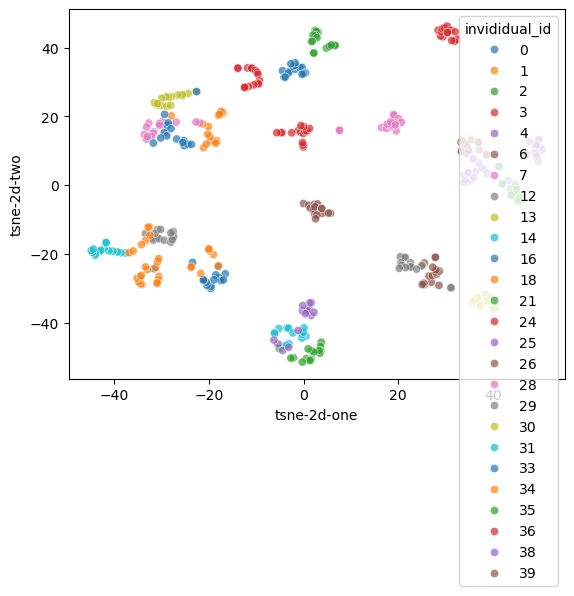

In [ ]:
# plot embeddings using t-SNE use one color for each individual_id

from sklearn.manifold import TSNE
import seaborn as sns

tsne = TSNE(n_components=2, random_state=42, perplexity=10)
X = torch.stack(embedding_img_table.embedding.to_list()).numpy().reshape(-1, 128)
print(X.shape)
X_2d = tsne.fit_transform(X)

embedding_img_table["tsne-2d-one"] = X_2d[:, 0]
embedding_img_table["tsne-2d-two"] = X_2d[:, 1]

sns.scatterplot(
    x="tsne-2d-one",
    y="tsne-2d-two",
    hue="invididual_id",
    palette=sns.color_palette("tab10", len(embedding_img_table.invididual_id.unique())),
    data=embedding_img_table,
    legend="full",
    alpha=0.7,
)

In [30]:
# plot a frame for each individual_id

import matplotlib.pyplot as plt

fig, ax = plt.subplots(
    len(embedding_img_table.invididual_id.unique()),
    1,
    figsize=(10 * len(embedding_img_table.invididual_id.unique()), 10),
)
for i, id in enumerate(embedding_img_table.invididual_id.unique()):
    img = embedding_img_table[embedding_img_table.invididual_id == id].iloc[10].frame_id
    bbox = embedding_img_table[embedding_img_table.invididual_id == id].iloc[10].bbox
    # get the frame from the video
    video = cv2.VideoCapture(video_path)
    video.set(cv2.CAP_PROP_POS_FRAMES, img)
    img = video.read()[1]
    img = _crop_image(img, bbox[0], bbox[1], bbox[2], bbox[3])
    video.release()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(img)
    # crop image
    ax[i].imshow(img)
    ax[i].set_title(f"Individual {id}")
    ax[i].axis("off")

plt.show()

ValueError: Number of rows must be a positive integer, not 0

<Figure size 0x1000 with 0 Axes>

In [79]:
# merge individual 19 20 and 67

embedding_img_table["invididual_id"] = embedding_img_table["invididual_id"].replace({28: 19})
embedding_img_table["invididual_id"] = embedding_img_table["invididual_id"].replace({67: 19})